## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Данные

Мы будем использовать данные из книги ISLR (Introduction to Statistical Learning: With Applications in R). Это будут продажи определённого продукта (в тысячах единиц), как функция от бюджета рекламы на ТВ, радио и в газетах (в тысячах долларов).

In [3]:
df = pd.read_csv("data/Advertising.csv")

In [4]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [5]:
# Берём все колонки, КРОМЕ sales
X = df.drop('sales',axis=1)

In [6]:
y = df['sales']

## SciKit Learn 

---

## Полиномиальная регрессия

**Прежде всего импортируем из Preprocessing класс PolynomialFeatures. С его помощью мы трансформируем наши исходные данные, добавляя в них полиномиальные признаки.**

Мы перейдём от уравнения в следующей форме (здесь показан случай, когда у нас только один признак x):

$$\hat{y} = \beta_0 + \beta_1x_1 + \epsilon $$

и добавим дополнительные признаки на основе исходного признака x для полинома некоторой степени *d*.

$$\hat{y} = \beta_0 + \beta_1x_1 + \beta_1x^2_1 +  ... + \beta_dx^d_1 + \epsilon$$

Далее мы применим линейную регрессию, поскольку по сути мы можем воспринимать эти полиномиальные признаки x^2, x^3, ... x^d как новые признаки. 

**Также нужно заметить, что когда у нас есть несколько признаков на основе признака X, то метод PolynomialFeatures также будет рассматривать *комбинации* признаков. Например, если на входе мы имеем два измерения в виде [a, b], то полином второй степени имеет следующие признаки: [1, a, b, a^2, ab, b^2].**

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [8]:
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False)

In [9]:
# Метод Converter "обучается" на данных, в данном случае, на основе всех колонок X
# Затем этот метод выполняет трансформацию и выдаёт на выходе новые полиномиальные данные
poly_features = polynomial_converter.fit_transform(X)

In [10]:
poly_features.shape

(200, 9)

In [11]:
X.shape

(200, 3)

In [12]:
X.iloc[0]

TV           230.1
radio         37.8
newspaper     69.2
Name: 0, dtype: float64

In [13]:
poly_features[0]

array([2.301000e+02, 3.780000e+01, 6.920000e+01, 5.294601e+04,
       8.697780e+03, 1.592292e+04, 1.428840e+03, 2.615760e+03,
       4.788640e+03])

In [14]:
poly_features[0][:3]

array([230.1,  37.8,  69.2])

In [15]:
poly_features[0][:3]**2

array([52946.01,  1428.84,  4788.64])

Комбинации признаков $$x_1  \cdot x_2 \text{  и  } x_1  \cdot x_3 \text{  и  }   x_2  \cdot x_3 $$

In [16]:
230.1*37.8

8697.779999999999

In [17]:
230.1*69.2

15922.92

In [18]:
37.8*69.2

2615.7599999999998

## Разбиение на обучающий и тестовый наборы данных - Train | Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# random_state: 
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

### Модель для обучения на полиномиальных данных

#### Создаём экземпляр модели с параметрами

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
model = LinearRegression(fit_intercept=True)

### Обучаем (Fit/Train) модель на обучающих данных

**Обучение следует проводить не на всех данных, а только на обучающих данных; тогда у нас будет возможность оценить работу модели на тестовых данных, чтобы проверить её способность работать с неизвестными данными в будущем.**

In [23]:
model.fit(X_train,y_train)

LinearRegression()


-----

## Оценка работы модели на тестовых данных

### Вычисляем производительность на тестовых данных

Чтобы корректно оценить работу модели, мы вычисляем метрики на тестовом наборе данных (это те данные, которые модель никогда не видела в процессе обучения).

In [24]:
test_predictions = model.predict(X_test)

In [25]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [26]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [27]:
MAE

0.4896798044803488

In [28]:
MSE

0.4417505510403312

In [29]:
RMSE

0.6646431757268942

In [30]:
df['sales'].mean()

14.0225

### Сравнение с простой линейной регрессией

**Результаты на тестовом наборе данных (замечание: для правильного сравнения следует использовать одно и то же разбиение данных на обучающую и тестовую выборки!)**

* Простая линейная регрессия:
    * MAE: 1.213
    * RMSE: 1.516

* Полиномиальная регрессия 2й степени:
    * MAE: 0.4896
    * RMSE: 0.664

---
---
## Выбираем модель

### Подбор параметров

Давайте посмотрим на дальнейшие степени полиномов, каждый раз смотря на ошибки предсказания.
С помощью цикла for сделаем следующее:

1. Создадим полиномиальные данные некоторой степени для данных X
2. Разобъём полиномиальные данные для обучающий и тестовый наборы данных
3. Выполним обучение модели на обучающем наборе данных
4. Посчитаем метрики на обучающем *и* тестовом наборе данных
5. Нанесём эти данные на график, чтобы увидеть момент переобучения модели

In [31]:
# Ошибка на обучающем наборе для той или иной степени полинома
train_rmse_errors = []
# Ошибка на тестовом наборе для той или иной степени полинома
test_rmse_errors = []

for d in range(1,10):
    
    # Создаём полиномиальные данные для степени "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    # Разбиваем эти новые полиномиальные данные на обучающий и тестовый наборы данных
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
    
    # Обучаем модель на этом новом наборе полиномиальных данных
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    
    # Выполняем предсказание и на обучающем, и на тестовом наборе данных
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Вычисляем ошибки
    
    # Ошибки на обучающем наборе данных
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    
    # Ошибки на тестовом наборе данных
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))

    # Добавляем ошибки в список для последующего нанесения на график
       
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

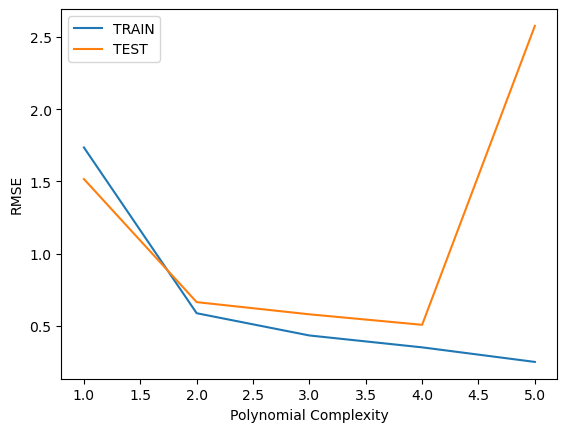

In [32]:
plt.plot(range(1,6),train_rmse_errors[:5],label='TRAIN')
plt.plot(range(1,6),test_rmse_errors[:5],label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

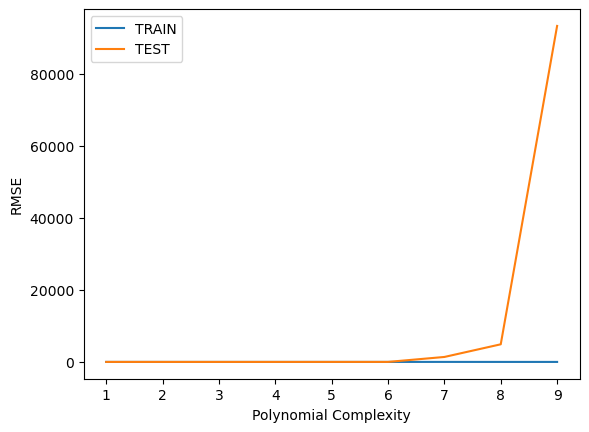

In [33]:
plt.plot(range(1,10),train_rmse_errors,label='TRAIN')
plt.plot(range(1,10),test_rmse_errors,label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

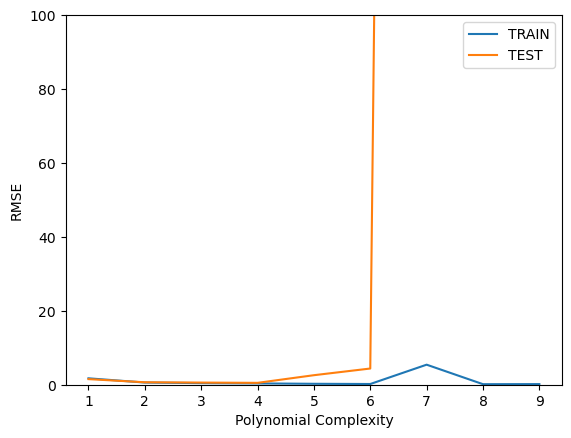

In [34]:
plt.plot(range(1,10),train_rmse_errors,label='TRAIN')
plt.plot(range(1,10),test_rmse_errors,label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.ylim(0,100)
plt.legend()

## Финальный выбор модели

Здесь нам нужно сохранить 2 вещи - объект создания полиномиальных признаков, а также саму модель. Дальнейшие шаги будут следующие:

1. Выбираем финальные значения параметров на основе тестовых метрик
2. Выполняем повторное обучение на всех данных
3. Сохраняем объект Polynomial Converter
4. Сохраняем модель

In [35]:
# На нашем графике видно, что мы могли бы выбрать и значение degree=4, однако
# безопаснее взять чуть меньшую степень сложности
final_poly_converter = PolynomialFeatures(degree=3,include_bias=False)

In [36]:
final_model = LinearRegression()

In [37]:
final_model.fit(final_poly_converter.fit_transform(X),y)

LinearRegression()

### Сохраняем модель и объект converter

In [38]:
from joblib import dump, load

In [39]:
dump(final_model, 'sales_poly_model.joblib') 

['sales_poly_model.joblib']

In [40]:
dump(final_poly_converter,'poly_converter.joblib')

['poly_converter.joblib']

## Внедрение модели и предсказания

### Предсказания на новых данных

**В нашей следующей рекламной кампании мы планируем потратить 149k на рекламу на ТВ, 22k на рекламу по радио и 12k на рекламу в газетах. Сколько единиц товара мы ожидаем продать в результате такой рекламы?**

In [41]:
loaded_poly = load('poly_converter.joblib')
loaded_model = load('sales_poly_model.joblib')

In [42]:
campaign = [[149,22,12]]

In [43]:
campaign_poly = loaded_poly.transform(campaign)

/Users/bulat/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [44]:
campaign_poly

array([[1.490000e+02, 2.200000e+01, 1.200000e+01, 2.220100e+04,
        3.278000e+03, 1.788000e+03, 4.840000e+02, 2.640000e+02,
        1.440000e+02, 3.307949e+06, 4.884220e+05, 2.664120e+05,
        7.211600e+04, 3.933600e+04, 2.145600e+04, 1.064800e+04,
        5.808000e+03, 3.168000e+03, 1.728000e+03]])

In [45]:
final_model.predict(campaign_poly)

array([14.64501014])

-----
---